In [1]:
from IPython import display
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import random
from torchvision.models import resnet18

In [2]:
colab = False
if colab:
    chemin = "/content/drive/Othercomputers/My laptop/Documents/Master ISN/M2/Projet_fevr/Projet1/Données"
else : 
    chemin = os.getcwd()+"/Données"  # mettre son propre répertoire à la place de "Données"

## Importation des données

In [3]:
typeFleur =  [species for species in os.listdir(chemin) if os.path.isdir(f"{chemin}/{species}")] # liste des espèce (17)
transform = transforms.Resize((224, 224))

Names={}
nb=0
# création dico({Espèce : list_fichier.jpg})
for type_ in typeFleur:     
    filenames = [name for name in os.listdir(f"{chemin}/{type_}") if os.path.splitext(name)[-1] == '.jpg']
    nb+=len(filenames)
    Names[type_]=filenames

    
batch = torch.zeros(nb, 3, 224, 224, dtype=torch.float32)
labels=np.empty(nb, dtype="U20")
i=-1

# on parcour le dico et on place chaque image dans le tensor batch
#                                      espece dans l'array labels
for espece, list_img in Names.items():
    for name in list_img:                                     
        i+=1 
        print(f"{i+1}/{nb}")
        display.clear_output(wait=True)
        image = transform(torchvision.io.read_image(f"{chemin}/{espece}/{name}"))/255.0   # redimension (224x224) et standardisation
        batch[i] = image
        labels[i]=espece

y = torch.as_tensor(preprocessing.LabelEncoder().fit_transform(labels))  # labels en chiffres
X = batch

1360/1360


In [4]:
typeFleurfr=['Jacinthe des bois',
   'Renoncule',
   'Tussilage',
   'Primevère',
   'Crocus',
   'Jonquille',
   'Marguerite',
   'Pissenlit',
   'Fritillaire',
   'Iris',
   'Muguet',
   'Pensée',
   'Perce-neige',
   'Tournesol',
   'Lys tigré',
   'Tulipe',
   'Anémone']

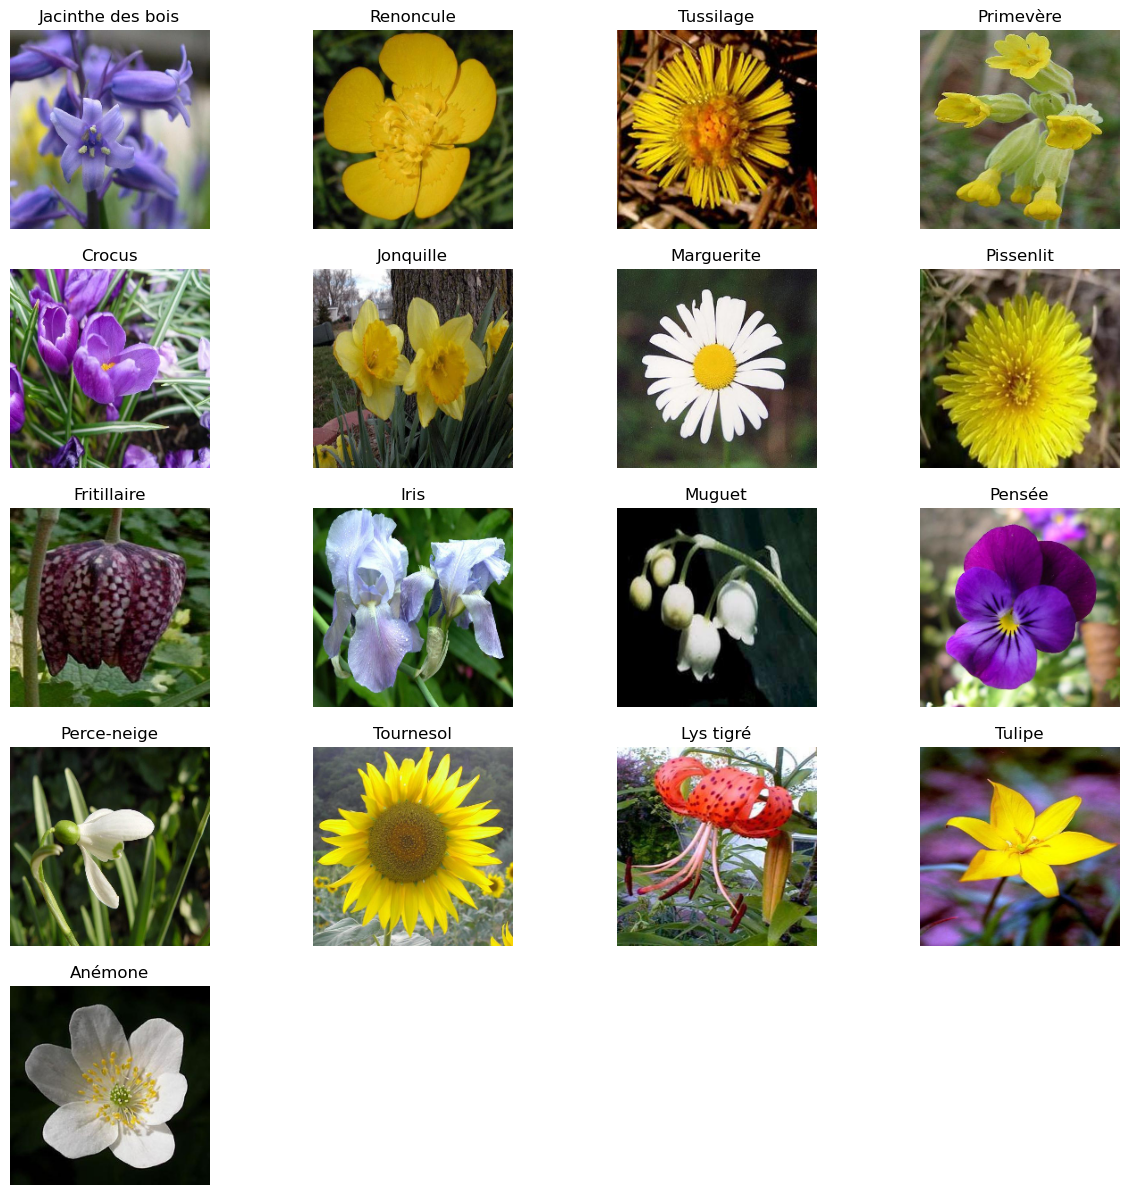

In [5]:
# représentation de la première image de chaque espèce

plt.figure(figsize=(15, 15))  
for i in range(17):
    img=i*80
    plt.subplot(5, 4, i+1)
    image = X[img]
    plt.title(typeFleurfr[i])
    plt.imshow(np.transpose(image, (1,2,0)))  # image.shape ==> (dim(RGB)=3, longueur, largeur)
    plt.axis('off');  

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # passage au GPU s'il est dispo

In [10]:
batch_size = 4 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = data.TensorDataset(X_train, y_train)
test_dataset = data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True)

In [11]:

model = resnet18(weights=None).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [12]:
num_epochs = 10
n_total_steps = len(train_loader)
accur = [0 for i in range(num_epochs)]
start_time = time.time()
for epoch in range(num_epochs):
    train_acc = 0
    n_samples = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        model.train()
        # Forward pass
        outputs = model(images)  #shape :  batch_size, 17
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        display.clear_output(wait=True)
#         _, predicted = torch.max(outputs, 1)
#         n_samples += labels.size(0)
#         train_acc += (predicted == labels).sum().item()
#         accur[epoch]=train_acc/n_samples*100 
        print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}') 
print(f'Finished Training')
end_time = time.time()


Epoch [10/10], Step [272/272], Loss: 0.6219
Finished Training


In [13]:
print(f"Durée d'exécution : {int((end_time-start_time)//60)} minutes et {int((end_time-start_time)%60)} secondes")

Durée d'exécution : 34 minutes et 51 secondes


In [14]:
# évaluation     
with torch.no_grad():
    prediction = []
    espece = []
    n_correct = 0
    n_samples = 0
    model.eval()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)        # shape : bach_size, 17 
        _, predicted = torch.max(outputs, 1)  # max sur chaque ligne
        n_samples += labels.size(0)  # incrémente de batch_size à chaque itération
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            espece.append(labels[i])
            prediction.append(predicted[i])

    acc = 100.0 * n_correct / n_samples
    accur.append(acc)
    print(f'Train Accuracy of the network: {acc} %')

Train Accuracy of the network: 80.69852941176471 %


In [15]:
# évaluation     
with torch.no_grad():
    prediction = []
    espece = []
    n_correct = 0
    n_samples = 0
    model.eval()
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)        # shape : bach_size, 17 
        _, predicted = torch.max(outputs, 1)  # max sur chaque ligne
        n_samples += labels.size(0)  # incrémente de batch_size à chaque itération
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            espece.append(labels[i])
            prediction.append(predicted[i])

    acc = 100.0 * n_correct / n_samples
    accur.append(acc)
    print(f'Test Accuracy of the network: {acc} %')

Test Accuracy of the network: 69.8529411764706 %


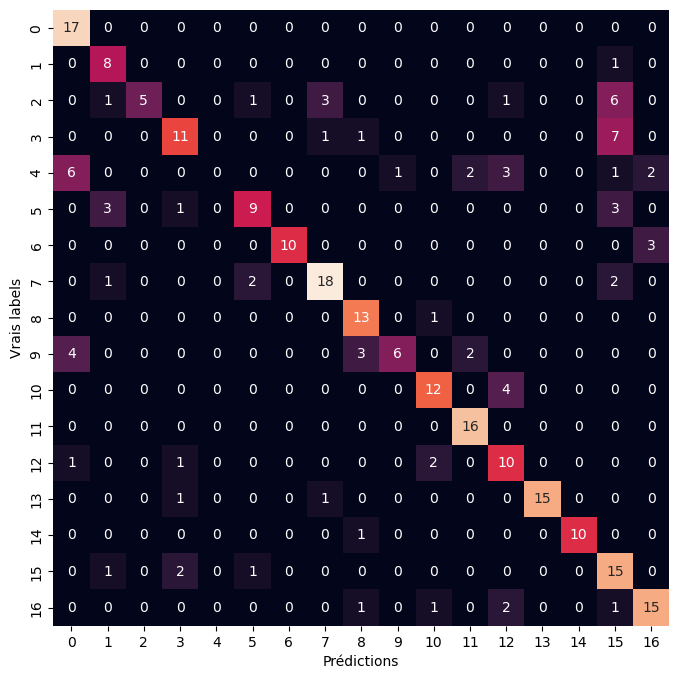

In [16]:
confusionX=confusion_matrix(espece,prediction)

plt.figure(figsize=(8,8))  # set plot size (denoted in inches)
sns.heatmap(confusionX,square=True, fmt='d', cbar=False ,annot=True)

plt.xlabel("Prédictions")
plt.ylabel("Vrais labels")
plt.show()

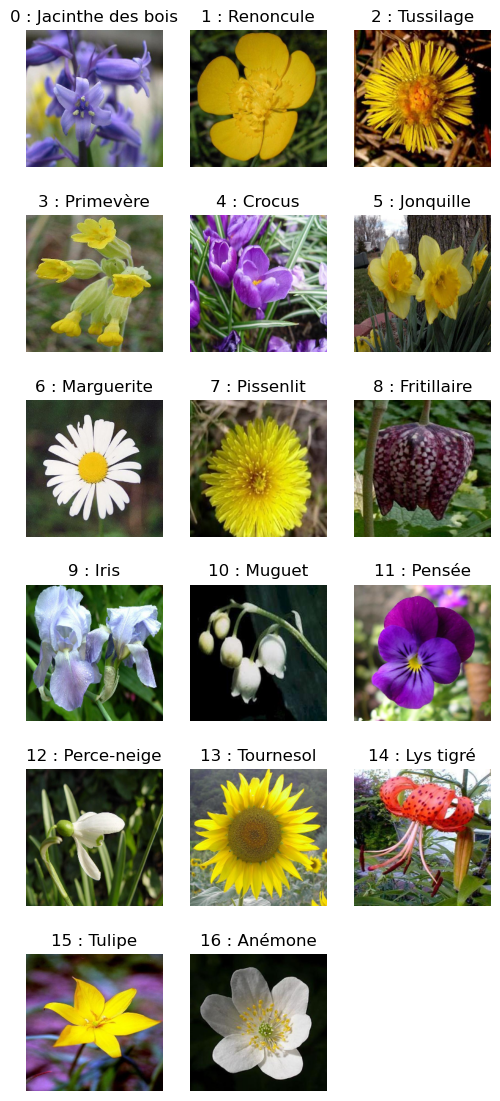

In [10]:
# show some images
plt.figure(figsize=(6, 14))
for i in range(17):
    img = (80*i)
    plt.subplot(6, 3, i+1)
    image = X[img]
    plt.title(f"{i} : {typeFleurfr[i]}")
    plt.imshow(np.transpose(image, (1,2,0)))  # image.shape ==> (dim(RGB)=3, longueur, largeur)
    plt.axis('off'); 